In [11]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import optuna as opt
import numpy as np
import os
import plotly
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from optuna.integration import XGBoostPruningCallback
import optuna.visualization as vis
import shap
from sklearn.preprocessing import StandardScaler
from optuna_dashboard import run_server


In [12]:
df = pd.read_csv("c:/Users/samud/Documents/Python_Learning/Asteroids/neo.csv/neo.csv")
df.dtypes

id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
orbiting_body          object
sentry_object            bool
absolute_magnitude    float64
hazardous                bool
dtype: object

In [13]:
df.select_dtypes(include =["float", "int", "bool"])

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,sentry_object,absolute_magnitude,hazardous
0,2162635,1.198271,2.679415,13569.249224,5.483974e+07,False,16.73,False
1,2277475,0.265800,0.594347,73588.726663,6.143813e+07,False,20.00,True
2,2512244,0.722030,1.614507,114258.692129,4.979872e+07,False,17.83,False
3,3596030,0.096506,0.215794,24764.303138,2.543497e+07,False,22.20,False
4,3667127,0.255009,0.570217,42737.733765,4.627557e+07,False,20.09,True
...,...,...,...,...,...,...,...,...
90831,3763337,0.026580,0.059435,52078.886692,1.230039e+07,False,25.00,False
90832,3837603,0.016771,0.037501,46114.605073,5.432121e+07,False,26.00,False
90833,54017201,0.031956,0.071456,7566.807732,2.840077e+07,False,24.60,False
90834,54115824,0.007321,0.016370,69199.154484,6.869206e+07,False,27.80,False


In [14]:
#for cl in df.select_dtypes(include =["float", "int"]).columns:
 #   df.hist(column= cl)

In [15]:
## These two columns are equal along all dataset -> They are not reliable features as predictors
df = df.drop(columns=['sentry_object','orbiting_body','name','id'])
df = df.drop_duplicates()
df['hazardous'] = df['hazardous'].astype(int)

In [16]:
# Detected Imbalanced dataset
df['hazardous'].value_counts()

hazardous
0    81996
1     8833
Name: count, dtype: int64

In [17]:
scaler = StandardScaler()
Y = df['hazardous']
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
X = df_scaled.drop(columns='hazardous')

In [18]:
def objective(trial):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, stratify = Y, random_state = 42)
    train = xgb.DMatrix(X_train, Y_train)
    test = xgb.DMatrix(X_test, Y_test)
    
    trial.set_user_attr('X_train', X_train)
    trial.set_user_attr('X_test', X_test)
    trial.set_user_attr('Y_train', Y_train)
    trial.set_user_attr('Y_test', Y_test)

    neg_count = (Y_train == 0).sum()
    pos_count = (Y_train == 1).sum()
    scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1


    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_float("eta", 1e-8, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "scale_pos_weight": scale_pos_weight
    }

    # Add a callback for pruning.
    pruning_callback = opt.integration.XGBoostPruningCallback(trial, "validation-auc")

    # Best Model
    bst = xgb.train(param, train, evals=[(test, "validation")])
    trial.set_user_attr("model", bst)
    preds = bst.predict(test)
    pred_labels = np.rint(preds)
    auc = roc_auc_score(Y_test, pred_labels)
    return auc

In [19]:
storage = opt.storages.InMemoryStorage()

study = opt.create_study(direction="maximize", storage= storage);  # Maximize AUC

study.optimize(objective, n_trials=100)

print("Best trial:")
print(f"AUC: {study.best_trial.value}")
print("Best parameters: ", study.best_trial.params)


[I 2024-12-23 17:29:58,532] A new study created in memory with name: no-name-537f5cd4-c376-48f1-81b3-5744750c6bf3


[0]	validation-auc:0.90681
[1]	validation-auc:0.90923
[2]	validation-auc:0.91129
[3]	validation-auc:0.91235
[4]	validation-auc:0.91333
[5]	validation-auc:0.91359
[6]	validation-auc:0.91347
[7]	validation-auc:0.91371
[8]	validation-auc:0.91376
[9]	validation-auc:0.91380


[I 2024-12-23 17:29:58,604] Trial 0 finished with value: 0.8768698989989763 and parameters: {'lambda': 0.2373818537686297, 'alpha': 0.49181403698672216, 'max_depth': 5, 'eta': 0.4781020680623642, 'gamma': 0.30790529526956883, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8768698989989763.


[0]	validation-auc:0.90972
[1]	validation-auc:0.91342
[2]	validation-auc:0.91330
[3]	validation-auc:0.91423
[4]	validation-auc:0.91359
[5]	validation-auc:0.91536
[6]	validation-auc:0.91521
[7]	validation-auc:0.91549
[8]	validation-auc:0.91568
[9]	validation-auc:0.91599


[I 2024-12-23 17:29:58,682] Trial 1 finished with value: 0.8670302960278922 and parameters: {'lambda': 0.9408310624283058, 'alpha': 0.3338754750373723, 'max_depth': 7, 'eta': 0.928753711422304, 'gamma': 0.16268113449578084, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8768698989989763.


[0]	validation-auc:0.90957
[1]	validation-auc:0.91142
[2]	validation-auc:0.91228
[3]	validation-auc:0.91225
[4]	validation-auc:0.91229
[5]	validation-auc:0.91307
[6]	validation-auc:0.91334
[7]	validation-auc:0.91323
[8]	validation-auc:0.91336
[9]	validation-auc:0.91347


[I 2024-12-23 17:29:58,771] Trial 2 finished with value: 0.8785676918682461 and parameters: {'lambda': 0.1848966563357165, 'alpha': 0.82342853495166, 'max_depth': 7, 'eta': 0.19617700455656567, 'gamma': 0.41252532107904727, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.91059
[1]	validation-auc:0.91242
[2]	validation-auc:0.91326
[3]	validation-auc:0.91379
[4]	validation-auc:0.91478
[5]	validation-auc:0.91508
[6]	validation-auc:0.91666
[7]	validation-auc:0.91681
[8]	validation-auc:0.91706
[9]	validation-auc:0.91691


[I 2024-12-23 17:29:58,982] Trial 3 finished with value: 0.8770795823023013 and parameters: {'lambda': 0.9020224813138443, 'alpha': 0.2676796537318828, 'max_depth': 9, 'eta': 0.169061140000827, 'gamma': 0.833644004598488, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.91071
[1]	validation-auc:0.91319
[2]	validation-auc:0.91347
[3]	validation-auc:0.91522
[4]	validation-auc:0.91423
[5]	validation-auc:0.91495
[6]	validation-auc:0.91572
[7]	validation-auc:0.91563
[8]	validation-auc:0.91508
[9]	validation-auc:0.91495


[I 2024-12-23 17:29:59,193] Trial 4 finished with value: 0.8649650224714173 and parameters: {'lambda': 0.30630270114914854, 'alpha': 0.8877656505337467, 'max_depth': 9, 'eta': 0.657738692481443, 'gamma': 0.09215831472452032, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.89979
[1]	validation-auc:0.90512
[2]	validation-auc:0.90538
[3]	validation-auc:0.90810
[4]	validation-auc:0.90916
[5]	validation-auc:0.91035
[6]	validation-auc:0.91139
[7]	validation-auc:0.91152
[8]	validation-auc:0.91197
[9]	validation-auc:0.91232


[I 2024-12-23 17:29:59,282] Trial 5 finished with value: 0.877490925313161 and parameters: {'lambda': 0.9186615843184367, 'alpha': 0.2452626773006238, 'max_depth': 3, 'eta': 0.41201352287942195, 'gamma': 0.6705494971516875, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.87094
[1]	validation-auc:0.87238
[2]	validation-auc:0.87238
[3]	validation-auc:0.87361
[4]	validation-auc:0.87485
[5]	validation-auc:0.87485
[6]	validation-auc:0.88298
[7]	validation-auc:0.90076
[8]	validation-auc:0.90076
[9]	validation-auc:0.90148


[I 2024-12-23 17:29:59,361] Trial 6 finished with value: 0.871000371225032 and parameters: {'lambda': 0.119024804428991, 'alpha': 0.5132256470907529, 'max_depth': 1, 'eta': 0.48735858547459854, 'gamma': 0.3126459232375938, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.91062
[1]	validation-auc:0.91259
[2]	validation-auc:0.91343
[3]	validation-auc:0.91485
[4]	validation-auc:0.91649
[5]	validation-auc:0.91603
[6]	validation-auc:0.91531
[7]	validation-auc:0.91502
[8]	validation-auc:0.91486
[9]	validation-auc:0.91401


[I 2024-12-23 17:29:59,470] Trial 7 finished with value: 0.8550109495337221 and parameters: {'lambda': 0.6728150692602847, 'alpha': 0.04066799321887085, 'max_depth': 9, 'eta': 0.7717486207998973, 'gamma': 0.687295707601418, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.87094
[1]	validation-auc:0.87238
[2]	validation-auc:0.87360
[3]	validation-auc:0.88179
[4]	validation-auc:0.89992
[5]	validation-auc:0.89993
[6]	validation-auc:0.90018
[7]	validation-auc:0.90081
[8]	validation-auc:0.90091
[9]	validation-auc:0.90483


[I 2024-12-23 17:29:59,549] Trial 8 finished with value: 0.8755978916129887 and parameters: {'lambda': 0.0817071203071147, 'alpha': 0.23394678675973654, 'max_depth': 1, 'eta': 0.8709481872814789, 'gamma': 0.5605809831233436, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.89248
[1]	validation-auc:0.89915
[2]	validation-auc:0.90070
[3]	validation-auc:0.90091
[4]	validation-auc:0.90249
[5]	validation-auc:0.90800
[6]	validation-auc:0.91062
[7]	validation-auc:0.91063
[8]	validation-auc:0.91064
[9]	validation-auc:0.91115


[I 2024-12-23 17:29:59,640] Trial 9 finished with value: 0.8766200977166987 and parameters: {'lambda': 0.955741888885313, 'alpha': 0.42807711267642706, 'max_depth': 2, 'eta': 0.7025676671463816, 'gamma': 0.9804293520956441, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.90760
[1]	validation-auc:0.90761
[2]	validation-auc:0.90761
[3]	validation-auc:0.90760
[4]	validation-auc:0.90763
[5]	validation-auc:0.90763
[6]	validation-auc:0.90761
[7]	validation-auc:0.90763
[8]	validation-auc:0.90763
[9]	validation-auc:0.90763


[I 2024-12-23 17:29:59,749] Trial 10 finished with value: 0.8780359949205291 and parameters: {'lambda': 0.5110472384879792, 'alpha': 0.9754323982225701, 'max_depth': 6, 'eta': 0.011140472591226663, 'gamma': 0.37089495199008016, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.90760
[1]	validation-auc:0.90761
[2]	validation-auc:0.90761
[3]	validation-auc:0.90761
[4]	validation-auc:0.90761
[5]	validation-auc:0.90761
[6]	validation-auc:0.90761
[7]	validation-auc:0.90760
[8]	validation-auc:0.90761
[9]	validation-auc:0.90761


[I 2024-12-23 17:29:59,873] Trial 11 finished with value: 0.8780359949205291 and parameters: {'lambda': 0.5015662994103021, 'alpha': 0.970856435193924, 'max_depth': 6, 'eta': 0.006458537837862155, 'gamma': 0.36854853480402233, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.90960
[1]	validation-auc:0.91143
[2]	validation-auc:0.91231
[3]	validation-auc:0.91223
[4]	validation-auc:0.91329
[5]	validation-auc:0.91330
[6]	validation-auc:0.91347
[7]	validation-auc:0.91347
[8]	validation-auc:0.91346
[9]	validation-auc:0.91361


[I 2024-12-23 17:29:59,999] Trial 12 finished with value: 0.8780541817376541 and parameters: {'lambda': 0.46826074472230794, 'alpha': 0.7660570912917484, 'max_depth': 7, 'eta': 0.22248425716057976, 'gamma': 0.45050034811479683, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.90972
[1]	validation-auc:0.91142
[2]	validation-auc:0.91367
[3]	validation-auc:0.91387
[4]	validation-auc:0.91478
[5]	validation-auc:0.91413
[6]	validation-auc:0.91466
[7]	validation-auc:0.91572
[8]	validation-auc:0.91585
[9]	validation-auc:0.91598


[I 2024-12-23 17:30:00,115] Trial 13 finished with value: 0.8776578161056033 and parameters: {'lambda': 0.6758618200931674, 'alpha': 0.7285791552529256, 'max_depth': 7, 'eta': 0.2798951775194397, 'gamma': 0.5118923378225635, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.90967
[1]	validation-auc:0.91127
[2]	validation-auc:0.91345
[3]	validation-auc:0.91364
[4]	validation-auc:0.91464
[5]	validation-auc:0.91446
[6]	validation-auc:0.91475
[7]	validation-auc:0.91519
[8]	validation-auc:0.91557
[9]	validation-auc:0.91555


[I 2024-12-23 17:30:00,226] Trial 14 finished with value: 0.8781237195678385 and parameters: {'lambda': 0.32681083149233836, 'alpha': 0.7041190112294325, 'max_depth': 7, 'eta': 0.26210567774019905, 'gamma': 0.19055473950177337, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.90378
[1]	validation-auc:0.90808
[2]	validation-auc:0.90969
[3]	validation-auc:0.91068
[4]	validation-auc:0.91088
[5]	validation-auc:0.91335
[6]	validation-auc:0.91364
[7]	validation-auc:0.91472
[8]	validation-auc:0.91460
[9]	validation-auc:0.91443


[I 2024-12-23 17:30:00,340] Trial 15 finished with value: 0.8784361048972819 and parameters: {'lambda': 0.26543765559723165, 'alpha': 0.6338523381234962, 'max_depth': 4, 'eta': 0.33834056885416997, 'gamma': 0.19038070026173837, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.90376
[1]	validation-auc:0.90803
[2]	validation-auc:0.90969
[3]	validation-auc:0.91068
[4]	validation-auc:0.91338
[5]	validation-auc:0.91412
[6]	validation-auc:0.91490
[7]	validation-auc:0.91485
[8]	validation-auc:0.91480
[9]	validation-auc:0.91478


[I 2024-12-23 17:30:00,449] Trial 16 finished with value: 0.8779702014350469 and parameters: {'lambda': 0.1729131094296414, 'alpha': 0.6128419999219217, 'max_depth': 4, 'eta': 0.3655796153437785, 'gamma': 0.02933128626244605, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.90378
[1]	validation-auc:0.90950
[2]	validation-auc:0.90909
[3]	validation-auc:0.91040
[4]	validation-auc:0.91058
[5]	validation-auc:0.91063
[6]	validation-auc:0.91050
[7]	validation-auc:0.91053
[8]	validation-auc:0.91057
[9]	validation-auc:0.91087


[I 2024-12-23 17:30:00,560] Trial 17 finished with value: 0.8768725735309063 and parameters: {'lambda': 0.3895557809558361, 'alpha': 0.8506296074616609, 'max_depth': 4, 'eta': 0.14741710428319, 'gamma': 0.22716740230597648, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.8785676918682461.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90924
[2]	validation-auc:0.91229
[3]	validation-auc:0.91311
[4]	validation-auc:0.91389
[5]	validation-auc:0.91371
[6]	validation-auc:0.91357
[7]	validation-auc:0.91359
[8]	validation-auc:0.91592
[9]	validation-auc:0.91730


[I 2024-12-23 17:30:00,671] Trial 18 finished with value: 0.8788945196701126 and parameters: {'lambda': 0.20948498849843292, 'alpha': 0.6084125517168173, 'max_depth': 5, 'eta': 0.594818774960048, 'gamma': 0.5822676860981685, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90955
[1]	validation-auc:0.91169
[2]	validation-auc:0.91419
[3]	validation-auc:0.91512
[4]	validation-auc:0.91521
[5]	validation-auc:0.91601
[6]	validation-auc:0.91686
[7]	validation-auc:0.91667
[8]	validation-auc:0.91753
[9]	validation-auc:0.91745


[I 2024-12-23 17:30:00,815] Trial 19 finished with value: 0.8738091646580932 and parameters: {'lambda': 0.005352631614533365, 'alpha': 0.8534088383529711, 'max_depth': 8, 'eta': 0.6400503092882364, 'gamma': 0.6251750838539641, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90924
[2]	validation-auc:0.91232
[3]	validation-auc:0.91258
[4]	validation-auc:0.91365
[5]	validation-auc:0.91451
[6]	validation-auc:0.91443
[7]	validation-auc:0.91364
[8]	validation-auc:0.91317
[9]	validation-auc:0.91601


[I 2024-12-23 17:30:00,942] Trial 20 finished with value: 0.8777883332637956 and parameters: {'lambda': 0.033772100083607204, 'alpha': 0.585152656668007, 'max_depth': 5, 'eta': 0.5627279409105148, 'gamma': 0.7907309495414173, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90378
[1]	validation-auc:0.90803
[2]	validation-auc:0.90967
[3]	validation-auc:0.91068
[4]	validation-auc:0.91340
[5]	validation-auc:0.91413
[6]	validation-auc:0.91489
[7]	validation-auc:0.91463
[8]	validation-auc:0.91460
[9]	validation-auc:0.91443


[I 2024-12-23 17:30:01,064] Trial 21 finished with value: 0.877909222107039 and parameters: {'lambda': 0.19742365394855316, 'alpha': 0.6426860561031899, 'max_depth': 4, 'eta': 0.3785332085370937, 'gamma': 0.4337175246261922, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.89979
[1]	validation-auc:0.90493
[2]	validation-auc:0.90514
[3]	validation-auc:0.90890
[4]	validation-auc:0.90896
[5]	validation-auc:0.91034
[6]	validation-auc:0.91041
[7]	validation-auc:0.91080
[8]	validation-auc:0.91089
[9]	validation-auc:0.91083


[I 2024-12-23 17:30:01,181] Trial 22 finished with value: 0.8770860011789336 and parameters: {'lambda': 0.28505592154590675, 'alpha': 0.7720886510523148, 'max_depth': 3, 'eta': 0.3242348886567734, 'gamma': 0.5339261144414112, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90775
[1]	validation-auc:0.91186
[2]	validation-auc:0.91182
[3]	validation-auc:0.91234
[4]	validation-auc:0.91229
[5]	validation-auc:0.91383
[6]	validation-auc:0.91391
[7]	validation-auc:0.91389
[8]	validation-auc:0.91393
[9]	validation-auc:0.91392


[I 2024-12-23 17:30:01,304] Trial 23 finished with value: 0.8784799672209366 and parameters: {'lambda': 0.41936557902282706, 'alpha': 0.6632307739404897, 'max_depth': 6, 'eta': 0.1148723548554908, 'gamma': 0.23498940687867592, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90775
[1]	validation-auc:0.91191
[2]	validation-auc:0.91179
[3]	validation-auc:0.91235
[4]	validation-auc:0.91203
[5]	validation-auc:0.91182
[6]	validation-auc:0.91238
[7]	validation-auc:0.91252
[8]	validation-auc:0.91271
[9]	validation-auc:0.91342


[I 2024-12-23 17:30:01,427] Trial 24 finished with value: 0.8783323330583914 and parameters: {'lambda': 0.3998460423813882, 'alpha': 0.5076717212553555, 'max_depth': 6, 'eta': 0.10158265772456311, 'gamma': 0.2662277209553201, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90958
[1]	validation-auc:0.90962
[2]	validation-auc:0.91180
[3]	validation-auc:0.91227
[4]	validation-auc:0.91282
[5]	validation-auc:0.91297
[6]	validation-auc:0.91296
[7]	validation-auc:0.91320
[8]	validation-auc:0.91327
[9]	validation-auc:0.91428


[I 2024-12-23 17:30:01,548] Trial 25 finished with value: 0.8783066575518619 and parameters: {'lambda': 0.13539696658468142, 'alpha': 0.8253008250006235, 'max_depth': 8, 'eta': 0.07045631205651859, 'gamma': 0.41862977862186207, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90763
[1]	validation-auc:0.91199
[2]	validation-auc:0.91230
[3]	validation-auc:0.91242
[4]	validation-auc:0.91241
[5]	validation-auc:0.91313
[6]	validation-auc:0.91316
[7]	validation-auc:0.91385
[8]	validation-auc:0.91429
[9]	validation-auc:0.91437


[I 2024-12-23 17:30:01,693] Trial 26 finished with value: 0.8777749606041446 and parameters: {'lambda': 0.586220065522998, 'alpha': 0.6807797261272799, 'max_depth': 6, 'eta': 0.19864455418475324, 'gamma': 0.5957045656286247, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90965
[2]	validation-auc:0.91235
[3]	validation-auc:0.91259
[4]	validation-auc:0.91367
[5]	validation-auc:0.91448
[6]	validation-auc:0.91453
[7]	validation-auc:0.91547
[8]	validation-auc:0.91569
[9]	validation-auc:0.91568


[I 2024-12-23 17:30:01,819] Trial 27 finished with value: 0.8775626027688894 and parameters: {'lambda': 0.40728145894696205, 'alpha': 0.4001273446047816, 'max_depth': 5, 'eta': 0.5730856423620789, 'gamma': 0.78563868300312, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90977
[1]	validation-auc:0.91229
[2]	validation-auc:0.91426
[3]	validation-auc:0.91434
[4]	validation-auc:0.91577
[5]	validation-auc:0.91561
[6]	validation-auc:0.91651
[7]	validation-auc:0.91721
[8]	validation-auc:0.91632
[9]	validation-auc:0.91537


[I 2024-12-23 17:30:01,953] Trial 28 finished with value: 0.8669789450148329 and parameters: {'lambda': 0.3428881959794441, 'alpha': 0.9193416683542676, 'max_depth': 8, 'eta': 0.7888820127795553, 'gamma': 0.4777646243751319, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90681
[1]	validation-auc:0.91189
[2]	validation-auc:0.91216
[3]	validation-auc:0.91195
[4]	validation-auc:0.91383
[5]	validation-auc:0.91448
[6]	validation-auc:0.91496
[7]	validation-auc:0.91491
[8]	validation-auc:0.91439
[9]	validation-auc:0.91454


[I 2024-12-23 17:30:02,083] Trial 29 finished with value: 0.8778359399321525 and parameters: {'lambda': 0.19072480693768834, 'alpha': 0.5670889072740541, 'max_depth': 5, 'eta': 0.44588292248669315, 'gamma': 0.32450145970521627, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90964
[2]	validation-auc:0.91134
[3]	validation-auc:0.91342
[4]	validation-auc:0.91389
[5]	validation-auc:0.91417
[6]	validation-auc:0.91446
[7]	validation-auc:0.91445
[8]	validation-auc:0.91635
[9]	validation-auc:0.91649


[I 2024-12-23 17:30:02,204] Trial 30 finished with value: 0.8786677193624344 and parameters: {'lambda': 0.23860251190328693, 'alpha': 0.7864667155462969, 'max_depth': 5, 'eta': 0.5131478104958018, 'gamma': 0.0022018952545778403, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90965
[2]	validation-auc:0.91235
[3]	validation-auc:0.91258
[4]	validation-auc:0.91365
[5]	validation-auc:0.91445
[6]	validation-auc:0.91456
[7]	validation-auc:0.91464
[8]	validation-auc:0.91433
[9]	validation-auc:0.91701


[I 2024-12-23 17:30:02,330] Trial 31 finished with value: 0.8775101819430582 and parameters: {'lambda': 0.2255227780045563, 'alpha': 0.7761473581068966, 'max_depth': 5, 'eta': 0.5868786434092613, 'gamma': 0.04639050461406091, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90771
[1]	validation-auc:0.91098
[2]	validation-auc:0.91209
[3]	validation-auc:0.91304
[4]	validation-auc:0.91343
[5]	validation-auc:0.91355
[6]	validation-auc:0.91343
[7]	validation-auc:0.91355
[8]	validation-auc:0.91311
[9]	validation-auc:0.91435


[I 2024-12-23 17:30:02,453] Trial 32 finished with value: 0.8782237470620267 and parameters: {'lambda': 0.08607394063376017, 'alpha': 0.6903534062421296, 'max_depth': 6, 'eta': 0.5048239272715243, 'gamma': 0.1183918968779906, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90775
[1]	validation-auc:0.91136
[2]	validation-auc:0.91174
[3]	validation-auc:0.91316
[4]	validation-auc:0.91359
[5]	validation-auc:0.91374
[6]	validation-auc:0.91396
[7]	validation-auc:0.91387
[8]	validation-auc:0.91427
[9]	validation-auc:0.91522


[I 2024-12-23 17:30:02,582] Trial 33 finished with value: 0.877427271453223 and parameters: {'lambda': 0.2197400131421991, 'alpha': 0.799466049800148, 'max_depth': 6, 'eta': 0.500093096120672, 'gamma': 0.1208233412670625, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90960
[1]	validation-auc:0.91321
[2]	validation-auc:0.91221
[3]	validation-auc:0.91379
[4]	validation-auc:0.91505
[5]	validation-auc:0.91635
[6]	validation-auc:0.91709
[7]	validation-auc:0.91750
[8]	validation-auc:0.91832
[9]	validation-auc:0.91844


[I 2024-12-23 17:30:02,715] Trial 34 finished with value: 0.8637625529156141 and parameters: {'lambda': 0.2595690689477665, 'alpha': 0.8893967899137356, 'max_depth': 7, 'eta': 0.9935523854684574, 'gamma': 0.2425775073192909, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.89979
[1]	validation-auc:0.90497
[2]	validation-auc:0.90762
[3]	validation-auc:0.91037
[4]	validation-auc:0.91114
[5]	validation-auc:0.91249
[6]	validation-auc:0.91279
[7]	validation-auc:0.91298
[8]	validation-auc:0.91305
[9]	validation-auc:0.91376


[I 2024-12-23 17:30:02,842] Trial 35 finished with value: 0.8772689391629571 and parameters: {'lambda': 0.8056260836646656, 'alpha': 0.5474023743892587, 'max_depth': 3, 'eta': 0.7195492669367695, 'gamma': 0.012446804165538315, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90890
[2]	validation-auc:0.90935
[3]	validation-auc:0.91049
[4]	validation-auc:0.91134
[5]	validation-auc:0.91138
[6]	validation-auc:0.91074
[7]	validation-auc:0.91149
[8]	validation-auc:0.91213
[9]	validation-auc:0.91206


[I 2024-12-23 17:30:02,970] Trial 36 finished with value: 0.878053111924882 and parameters: {'lambda': 0.3390678271294958, 'alpha': 0.42209563993622334, 'max_depth': 5, 'eta': 0.12379494038290233, 'gamma': 0.7057531503257074, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90972
[1]	validation-auc:0.91157
[2]	validation-auc:0.91237
[3]	validation-auc:0.91238
[4]	validation-auc:0.91702
[5]	validation-auc:0.91622
[6]	validation-auc:0.91615
[7]	validation-auc:0.91590
[8]	validation-auc:0.91545
[9]	validation-auc:0.91575


[I 2024-12-23 17:30:03,126] Trial 37 finished with value: 0.8683889582484169 and parameters: {'lambda': 0.15403378472291399, 'alpha': 0.6590306982732576, 'max_depth': 8, 'eta': 0.6283078077420776, 'gamma': 0.36669640571632156, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90378
[1]	validation-auc:0.90802
[2]	validation-auc:0.90969
[3]	validation-auc:0.91334
[4]	validation-auc:0.91407
[5]	validation-auc:0.91434
[6]	validation-auc:0.91465
[7]	validation-auc:0.91459
[8]	validation-auc:0.91468
[9]	validation-auc:0.91506


[I 2024-12-23 17:30:03,248] Trial 38 finished with value: 0.8784580360591093 and parameters: {'lambda': 0.5716859438961965, 'alpha': 0.7358690545347165, 'max_depth': 4, 'eta': 0.42583441816576384, 'gamma': 0.26098279631177373, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90766
[1]	validation-auc:0.90760
[2]	validation-auc:0.91194
[3]	validation-auc:0.91173
[4]	validation-auc:0.91191
[5]	validation-auc:0.91206
[6]	validation-auc:0.91398
[7]	validation-auc:0.91399
[8]	validation-auc:0.91403
[9]	validation-auc:0.91409


[I 2024-12-23 17:30:03,370] Trial 39 finished with value: 0.8782103744023758 and parameters: {'lambda': 0.09137675373849852, 'alpha': 0.05024960455821453, 'max_depth': 6, 'eta': 0.0763160614391224, 'gamma': 0.16737951219693034, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90956
[1]	validation-auc:0.91101
[2]	validation-auc:0.91317
[3]	validation-auc:0.91385
[4]	validation-auc:0.91367
[5]	validation-auc:0.91546
[6]	validation-auc:0.91561
[7]	validation-auc:0.91623
[8]	validation-auc:0.91594
[9]	validation-auc:0.91709


[I 2024-12-23 17:30:03,515] Trial 40 finished with value: 0.8758915552189211 and parameters: {'lambda': 0.4466978179840708, 'alpha': 0.5436372551908262, 'max_depth': 7, 'eta': 0.5321911951277682, 'gamma': 0.07755710872459554, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90378
[1]	validation-auc:0.90803
[2]	validation-auc:0.90969
[3]	validation-auc:0.91333
[4]	validation-auc:0.91402
[5]	validation-auc:0.91426
[6]	validation-auc:0.91444
[7]	validation-auc:0.91447
[8]	validation-auc:0.91465
[9]	validation-auc:0.91459


[I 2024-12-23 17:30:03,641] Trial 41 finished with value: 0.8772298909967766 and parameters: {'lambda': 0.5609279437540131, 'alpha': 0.7356305394689409, 'max_depth': 4, 'eta': 0.44142036879395763, 'gamma': 0.29143015628897334, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.89248
[1]	validation-auc:0.89874
[2]	validation-auc:0.90058
[3]	validation-auc:0.90364
[4]	validation-auc:0.90524
[5]	validation-auc:0.90543
[6]	validation-auc:0.90544
[7]	validation-auc:0.90666
[8]	validation-auc:0.90689
[9]	validation-auc:0.90671


[I 2024-12-23 17:30:03,759] Trial 42 finished with value: 0.8761750556035188 and parameters: {'lambda': 0.6579453271410254, 'alpha': 0.9286288838508275, 'max_depth': 2, 'eta': 0.28557589088275415, 'gamma': 0.392624079999196, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90682
[1]	validation-auc:0.91162
[2]	validation-auc:0.91209
[3]	validation-auc:0.91204
[4]	validation-auc:0.91410
[5]	validation-auc:0.91436
[6]	validation-auc:0.91496
[7]	validation-auc:0.91480
[8]	validation-auc:0.91437
[9]	validation-auc:0.91445


[I 2024-12-23 17:30:03,882] Trial 43 finished with value: 0.8779750155925212 and parameters: {'lambda': 0.576602561433695, 'alpha': 0.7377463995466161, 'max_depth': 5, 'eta': 0.41377518329586777, 'gamma': 0.33827408097222894, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90378
[1]	validation-auc:0.90955
[2]	validation-auc:0.90910
[3]	validation-auc:0.91039
[4]	validation-auc:0.91065
[5]	validation-auc:0.91060
[6]	validation-auc:0.91315
[7]	validation-auc:0.91346
[8]	validation-auc:0.91348
[9]	validation-auc:0.91371


[I 2024-12-23 17:30:04,011] Trial 44 finished with value: 0.8771774701709454 and parameters: {'lambda': 0.5298161688859306, 'alpha': 0.8145613751853885, 'max_depth': 4, 'eta': 0.20090370571975194, 'gamma': 0.5679770080867382, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.89979
[1]	validation-auc:0.90497
[2]	validation-auc:0.90762
[3]	validation-auc:0.91037
[4]	validation-auc:0.91113
[5]	validation-auc:0.91251
[6]	validation-auc:0.91280
[7]	validation-auc:0.91297
[8]	validation-auc:0.91369
[9]	validation-auc:0.91376


[I 2024-12-23 17:30:04,126] Trial 45 finished with value: 0.8772689391629571 and parameters: {'lambda': 0.756885714239832, 'alpha': 0.998934327100416, 'max_depth': 3, 'eta': 0.7298817166291118, 'gamma': 0.48562707185197523, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90683
[2]	validation-auc:0.90890
[3]	validation-auc:0.90902
[4]	validation-auc:0.90902
[5]	validation-auc:0.90903
[6]	validation-auc:0.90926
[7]	validation-auc:0.90965
[8]	validation-auc:0.91056
[9]	validation-auc:0.90958


[I 2024-12-23 17:30:04,241] Trial 46 finished with value: 0.8775652773008196 and parameters: {'lambda': 0.4439177350991056, 'alpha': 0.4650972565608078, 'max_depth': 5, 'eta': 0.04451497198582907, 'gamma': 0.9316237533927283, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90956
[1]	validation-auc:0.91135
[2]	validation-auc:0.91243
[3]	validation-auc:0.91235
[4]	validation-auc:0.91328
[5]	validation-auc:0.91319
[6]	validation-auc:0.91357
[7]	validation-auc:0.91398
[8]	validation-auc:0.91408
[9]	validation-auc:0.91486


[I 2024-12-23 17:30:04,357] Trial 47 finished with value: 0.877588278275419 and parameters: {'lambda': 0.30775725504124146, 'alpha': 0.6091112253547779, 'max_depth': 7, 'eta': 0.23473483749361124, 'gamma': 0.21496450728067845, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.89248
[1]	validation-auc:0.89874
[2]	validation-auc:0.90069
[3]	validation-auc:0.90406
[4]	validation-auc:0.90528
[5]	validation-auc:0.90672
[6]	validation-auc:0.91050
[7]	validation-auc:0.91051
[8]	validation-auc:0.91286
[9]	validation-auc:0.91288


[I 2024-12-23 17:30:04,492] Trial 48 finished with value: 0.8770774426767571 and parameters: {'lambda': 0.6280145292553605, 'alpha': 0.3448072194658254, 'max_depth': 2, 'eta': 0.6734222808941618, 'gamma': 0.27112785635368597, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90763
[1]	validation-auc:0.91233
[2]	validation-auc:0.91393
[3]	validation-auc:0.91371
[4]	validation-auc:0.91343
[5]	validation-auc:0.91434
[6]	validation-auc:0.91845
[7]	validation-auc:0.91882
[8]	validation-auc:0.91918
[9]	validation-auc:0.91997


[I 2024-12-23 17:30:04,626] Trial 49 finished with value: 0.8749923775839991 and parameters: {'lambda': 0.3812303516146338, 'alpha': 0.8574521135017934, 'max_depth': 6, 'eta': 0.8183915756323401, 'gamma': 0.15072885956649837, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.89979
[1]	validation-auc:0.90336
[2]	validation-auc:0.90426
[3]	validation-auc:0.90529
[4]	validation-auc:0.90541
[5]	validation-auc:0.90546
[6]	validation-auc:0.90634
[7]	validation-auc:0.90642
[8]	validation-auc:0.91015
[9]	validation-auc:0.91054


[I 2024-12-23 17:30:04,749] Trial 50 finished with value: 0.8765066975628595 and parameters: {'lambda': 0.04664473726903792, 'alpha': 0.7197323684560942, 'max_depth': 3, 'eta': 0.16457977652754047, 'gamma': 0.678148249985728, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90378
[1]	validation-auc:0.90796
[2]	validation-auc:0.90954
[3]	validation-auc:0.91068
[4]	validation-auc:0.91088
[5]	validation-auc:0.91338
[6]	validation-auc:0.91375
[7]	validation-auc:0.91437
[8]	validation-auc:0.91466
[9]	validation-auc:0.91451


[I 2024-12-23 17:30:04,883] Trial 51 finished with value: 0.8779787599372234 and parameters: {'lambda': 0.24884316221238884, 'alpha': 0.6283437860176324, 'max_depth': 4, 'eta': 0.3175694864539519, 'gamma': 0.18662202923563953, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90378
[1]	validation-auc:0.90803
[2]	validation-auc:0.90969
[3]	validation-auc:0.91068
[4]	validation-auc:0.91340
[5]	validation-auc:0.91412
[6]	validation-auc:0.91490
[7]	validation-auc:0.91485
[8]	validation-auc:0.91480
[9]	validation-auc:0.91453


[I 2024-12-23 17:30:05,016] Trial 52 finished with value: 0.8780006910990508 and parameters: {'lambda': 0.28334505752610256, 'alpha': 0.6608938397012606, 'max_depth': 4, 'eta': 0.3629827820928531, 'gamma': 0.14349800579469488, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90681
[1]	validation-auc:0.91189
[2]	validation-auc:0.91216
[3]	validation-auc:0.91306
[4]	validation-auc:0.91343
[5]	validation-auc:0.91407
[6]	validation-auc:0.91401
[7]	validation-auc:0.91475
[8]	validation-auc:0.91589
[9]	validation-auc:0.91688


[I 2024-12-23 17:30:05,141] Trial 53 finished with value: 0.878437174710054 and parameters: {'lambda': 0.14434819127324527, 'alpha': 0.5933754010454655, 'max_depth': 5, 'eta': 0.45077329950312683, 'gamma': 0.08970007184643047, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90922
[2]	validation-auc:0.91187
[3]	validation-auc:0.91267
[4]	validation-auc:0.91295
[5]	validation-auc:0.91329
[6]	validation-auc:0.91403
[7]	validation-auc:0.91453
[8]	validation-auc:0.91423
[9]	validation-auc:0.91359


[I 2024-12-23 17:30:05,271] Trial 54 finished with value: 0.8766564713509489 and parameters: {'lambda': 0.1165560556591112, 'alpha': 0.5919423780401963, 'max_depth': 5, 'eta': 0.6006435250217577, 'gamma': 0.05658588892941306, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90681
[1]	validation-auc:0.91187
[2]	validation-auc:0.91215
[3]	validation-auc:0.91306
[4]	validation-auc:0.91345
[5]	validation-auc:0.91409
[6]	validation-auc:0.91399
[7]	validation-auc:0.91471
[8]	validation-auc:0.91633
[9]	validation-auc:0.91673


[I 2024-12-23 17:30:05,407] Trial 55 finished with value: 0.8782542367260305 and parameters: {'lambda': 0.14995793745937802, 'alpha': 0.7655059476749844, 'max_depth': 5, 'eta': 0.46162492590884396, 'gamma': 0.09388610701772515, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90768
[1]	validation-auc:0.91136
[2]	validation-auc:0.91203
[3]	validation-auc:0.91297
[4]	validation-auc:0.91302
[5]	validation-auc:0.91409
[6]	validation-auc:0.91483
[7]	validation-auc:0.91614
[8]	validation-auc:0.91591
[9]	validation-auc:0.91686


[I 2024-12-23 17:30:05,526] Trial 56 finished with value: 0.8766136788400661 and parameters: {'lambda': 0.7261710894092895, 'alpha': 0.698758282820017, 'max_depth': 6, 'eta': 0.5371594034817089, 'gamma': 0.0018413501965257734, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90761
[1]	validation-auc:0.91206
[2]	validation-auc:0.91286
[3]	validation-auc:0.91262
[4]	validation-auc:0.91388
[5]	validation-auc:0.91455
[6]	validation-auc:0.91447
[7]	validation-auc:0.91617
[8]	validation-auc:0.91595
[9]	validation-auc:0.91640


[I 2024-12-23 17:30:05,649] Trial 57 finished with value: 0.8787944921759243 and parameters: {'lambda': 0.18075396027417426, 'alpha': 0.7443962523241314, 'max_depth': 6, 'eta': 0.3974574689381045, 'gamma': 0.6181589621212014, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90957
[1]	validation-auc:0.91219
[2]	validation-auc:0.91426
[3]	validation-auc:0.91460
[4]	validation-auc:0.91471
[5]	validation-auc:0.91505
[6]	validation-auc:0.91656
[7]	validation-auc:0.91720
[8]	validation-auc:0.91702
[9]	validation-auc:0.91716


[I 2024-12-23 17:30:05,786] Trial 58 finished with value: 0.8770795823023013 and parameters: {'lambda': 0.20485789730491494, 'alpha': 0.8315519524738789, 'max_depth': 7, 'eta': 0.4154474030005626, 'gamma': 0.6180721041304167, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91179
[2]	validation-auc:0.91382
[3]	validation-auc:0.91414
[4]	validation-auc:0.91492
[5]	validation-auc:0.91474
[6]	validation-auc:0.91490
[7]	validation-auc:0.91497
[8]	validation-auc:0.91456
[9]	validation-auc:0.91441


[I 2024-12-23 17:30:05,908] Trial 59 finished with value: 0.8783933123863993 and parameters: {'lambda': 0.4858586037435107, 'alpha': 0.891659672698374, 'max_depth': 6, 'eta': 0.26144053011759405, 'gamma': 0.549424962767422, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90960
[1]	validation-auc:0.91222
[2]	validation-auc:0.91442
[3]	validation-auc:0.91467
[4]	validation-auc:0.91509
[5]	validation-auc:0.91507
[6]	validation-auc:0.91557
[7]	validation-auc:0.91591
[8]	validation-auc:0.91675
[9]	validation-auc:0.91682


[I 2024-12-23 17:30:06,041] Trial 60 finished with value: 0.8777064925867323 and parameters: {'lambda': 0.36383567973801123, 'alpha': 0.7744757162332757, 'max_depth': 7, 'eta': 0.39008330948158854, 'gamma': 0.5104427192960928, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90759
[1]	validation-auc:0.91191
[2]	validation-auc:0.91225
[3]	validation-auc:0.91320
[4]	validation-auc:0.91342
[5]	validation-auc:0.91326
[6]	validation-auc:0.91329
[7]	validation-auc:0.91480
[8]	validation-auc:0.91483
[9]	validation-auc:0.91690


[I 2024-12-23 17:30:06,168] Trial 61 finished with value: 0.877362547780513 and parameters: {'lambda': 0.17969017427295048, 'alpha': 0.6563701858093931, 'max_depth': 6, 'eta': 0.46816194692292507, 'gamma': 0.7446386447213934, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90376
[1]	validation-auc:0.90808
[2]	validation-auc:0.90946
[3]	validation-auc:0.91130
[4]	validation-auc:0.91143
[5]	validation-auc:0.91238
[6]	validation-auc:0.91339
[7]	validation-auc:0.91404
[8]	validation-auc:0.91440
[9]	validation-auc:0.91428


[I 2024-12-23 17:30:06,294] Trial 62 finished with value: 0.8782665395729093 and parameters: {'lambda': 0.05330182881191804, 'alpha': 0.7430361777353867, 'max_depth': 4, 'eta': 0.5049220261566105, 'gamma': 0.6276387384307144, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90682
[1]	validation-auc:0.90965
[2]	validation-auc:0.91240
[3]	validation-auc:0.91226
[4]	validation-auc:0.91361
[5]	validation-auc:0.91438
[6]	validation-auc:0.91436
[7]	validation-auc:0.91415
[8]	validation-auc:0.91441
[9]	validation-auc:0.91529


[I 2024-12-23 17:30:06,404] Trial 63 finished with value: 0.8781761403936698 and parameters: {'lambda': 0.9974524489183423, 'alpha': 0.49422612005510735, 'max_depth': 5, 'eta': 0.5511575367211512, 'gamma': 0.6484985530706837, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90897
[2]	validation-auc:0.91075
[3]	validation-auc:0.91083
[4]	validation-auc:0.91076
[5]	validation-auc:0.91214
[6]	validation-auc:0.91320
[7]	validation-auc:0.91399
[8]	validation-auc:0.91437
[9]	validation-auc:0.91427


[I 2024-12-23 17:30:06,529] Trial 64 finished with value: 0.8781140912528898 and parameters: {'lambda': 0.12265298256735442, 'alpha': 0.6944652484684048, 'max_depth': 5, 'eta': 0.3087203288073706, 'gamma': 0.4664036515469454, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90775
[1]	validation-auc:0.91192
[2]	validation-auc:0.91183
[3]	validation-auc:0.91234
[4]	validation-auc:0.91242
[5]	validation-auc:0.91250
[6]	validation-auc:0.91249
[7]	validation-auc:0.91310
[8]	validation-auc:0.91314
[9]	validation-auc:0.91333


[I 2024-12-23 17:30:06,663] Trial 65 finished with value: 0.8785323880467679 and parameters: {'lambda': 0.30190392597151827, 'alpha': 0.8007945343582682, 'max_depth': 6, 'eta': 0.13251933149152245, 'gamma': 0.09210278778873454, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90977
[1]	validation-auc:0.91249
[2]	validation-auc:0.91251
[3]	validation-auc:0.91286
[4]	validation-auc:0.91437
[5]	validation-auc:0.91427
[6]	validation-auc:0.91435
[7]	validation-auc:0.91578
[8]	validation-auc:0.91557
[9]	validation-auc:0.91619


[I 2024-12-23 17:30:06,797] Trial 66 finished with value: 0.8773186854568581 and parameters: {'lambda': 0.3020390572857606, 'alpha': 0.953607380277102, 'max_depth': 8, 'eta': 0.14270057528667182, 'gamma': 0.4245716928444139, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90775
[1]	validation-auc:0.90774
[2]	validation-auc:0.90773
[3]	validation-auc:0.91183
[4]	validation-auc:0.91085
[5]	validation-auc:0.91179
[6]	validation-auc:0.91154
[7]	validation-auc:0.91197
[8]	validation-auc:0.91172
[9]	validation-auc:0.91188


[I 2024-12-23 17:30:06,930] Trial 67 finished with value: 0.8780884157463602 and parameters: {'lambda': 0.23824794061546073, 'alpha': 0.8075532836595413, 'max_depth': 6, 'eta': 0.03699811052813903, 'gamma': 0.03403851881532592, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90960
[1]	validation-auc:0.90970
[2]	validation-auc:0.91119
[3]	validation-auc:0.91182
[4]	validation-auc:0.91243
[5]	validation-auc:0.91255
[6]	validation-auc:0.91275
[7]	validation-auc:0.91272
[8]	validation-auc:0.91286
[9]	validation-auc:0.91332


[I 2024-12-23 17:30:07,064] Trial 68 finished with value: 0.878101788406011 and parameters: {'lambda': 0.3259192294170517, 'alpha': 0.8540913712518431, 'max_depth': 7, 'eta': 0.10490754708743791, 'gamma': 0.2505893354523475, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.91067
[1]	validation-auc:0.91274
[2]	validation-auc:0.91378
[3]	validation-auc:0.91409
[4]	validation-auc:0.91466
[5]	validation-auc:0.91525
[6]	validation-auc:0.91701
[7]	validation-auc:0.91698
[8]	validation-auc:0.91682
[9]	validation-auc:0.91746


[I 2024-12-23 17:30:07,215] Trial 69 finished with value: 0.8776931199270817 and parameters: {'lambda': 0.43274523907602547, 'alpha': 0.8003508556860798, 'max_depth': 9, 'eta': 0.19900956666675004, 'gamma': 0.5906811004402407, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.8788945196701126.


[0]	validation-auc:0.90763
[1]	validation-auc:0.91183
[2]	validation-auc:0.91385
[3]	validation-auc:0.91411
[4]	validation-auc:0.91399
[5]	validation-auc:0.91475
[6]	validation-auc:0.91493
[7]	validation-auc:0.91480
[8]	validation-auc:0.91502
[9]	validation-auc:0.91524


[I 2024-12-23 17:30:07,343] Trial 70 finished with value: 0.8790507123348342 and parameters: {'lambda': 0.21239420108210125, 'alpha': 0.8737161740782626, 'max_depth': 6, 'eta': 0.2426863600954678, 'gamma': 0.7165500892176775, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91181
[2]	validation-auc:0.91383
[3]	validation-auc:0.91413
[4]	validation-auc:0.91492
[5]	validation-auc:0.91471
[6]	validation-auc:0.91497
[7]	validation-auc:0.91503
[8]	validation-auc:0.91475
[9]	validation-auc:0.91474


[I 2024-12-23 17:30:07,474] Trial 71 finished with value: 0.8787067675286149 and parameters: {'lambda': 0.20864601309902037, 'alpha': 0.8986701363317051, 'max_depth': 6, 'eta': 0.2549758660420989, 'gamma': 0.7165263971383232, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91182
[2]	validation-auc:0.91255
[3]	validation-auc:0.91254
[4]	validation-auc:0.91330
[5]	validation-auc:0.91325
[6]	validation-auc:0.91378
[7]	validation-auc:0.91482
[8]	validation-auc:0.91480
[9]	validation-auc:0.91481


[I 2024-12-23 17:30:07,597] Trial 72 finished with value: 0.877300498639733 and parameters: {'lambda': 0.26534754478136713, 'alpha': 0.9195848643319691, 'max_depth': 6, 'eta': 0.22818144951788233, 'gamma': 0.7254523589500924, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91198
[2]	validation-auc:0.91225
[3]	validation-auc:0.91237
[4]	validation-auc:0.91271
[5]	validation-auc:0.91263
[6]	validation-auc:0.91284
[7]	validation-auc:0.91354
[8]	validation-auc:0.91399
[9]	validation-auc:0.91469


[I 2024-12-23 17:30:07,715] Trial 73 finished with value: 0.8787677468566226 and parameters: {'lambda': 0.2256476998992737, 'alpha': 0.8762860703895434, 'max_depth': 6, 'eta': 0.17490745959856768, 'gamma': 0.8240973486665293, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91197
[2]	validation-auc:0.91225
[3]	validation-auc:0.91213
[4]	validation-auc:0.91244
[5]	validation-auc:0.91362
[6]	validation-auc:0.91352
[7]	validation-auc:0.91417
[8]	validation-auc:0.91489
[9]	validation-auc:0.91514


[I 2024-12-23 17:30:07,842] Trial 74 finished with value: 0.8784323605525797 and parameters: {'lambda': 0.17302538165806708, 'alpha': 0.8676249642078151, 'max_depth': 6, 'eta': 0.17031429507996376, 'gamma': 0.8658745283391603, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90969
[1]	validation-auc:0.91145
[2]	validation-auc:0.91338
[3]	validation-auc:0.91364
[4]	validation-auc:0.91456
[5]	validation-auc:0.91416
[6]	validation-auc:0.91454
[7]	validation-auc:0.91458
[8]	validation-auc:0.91444
[9]	validation-auc:0.91471


[I 2024-12-23 17:30:07,975] Trial 75 finished with value: 0.8785286437020657 and parameters: {'lambda': 0.20347852344674924, 'alpha': 0.8933040917846342, 'max_depth': 7, 'eta': 0.25033068316692375, 'gamma': 0.8131885886425406, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91179
[2]	validation-auc:0.91216
[3]	validation-auc:0.91226
[4]	validation-auc:0.91303
[5]	validation-auc:0.91435
[6]	validation-auc:0.91471
[7]	validation-auc:0.91518
[8]	validation-auc:0.91558
[9]	validation-auc:0.91541


[I 2024-12-23 17:30:08,117] Trial 76 finished with value: 0.8779712712478188 and parameters: {'lambda': 0.22742261890106905, 'alpha': 0.932521052107882, 'max_depth': 6, 'eta': 0.2828142681147312, 'gamma': 0.7384856313759233, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90970
[1]	validation-auc:0.91146
[2]	validation-auc:0.91237
[3]	validation-auc:0.91233
[4]	validation-auc:0.91229
[5]	validation-auc:0.91284
[6]	validation-auc:0.91378
[7]	validation-auc:0.91362
[8]	validation-auc:0.91395
[9]	validation-auc:0.91408


[I 2024-12-23 17:30:08,243] Trial 77 finished with value: 0.8787115816860891 and parameters: {'lambda': 0.09701514096000086, 'alpha': 0.9609037630546456, 'max_depth': 7, 'eta': 0.18731870367087633, 'gamma': 0.762471446601234, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90968
[1]	validation-auc:0.91199
[2]	validation-auc:0.91247
[3]	validation-auc:0.91285
[4]	validation-auc:0.91400
[5]	validation-auc:0.91413
[6]	validation-auc:0.91590
[7]	validation-auc:0.91577
[8]	validation-auc:0.91644
[9]	validation-auc:0.91654


[I 2024-12-23 17:30:08,409] Trial 78 finished with value: 0.8773491751208621 and parameters: {'lambda': 0.08755274067696883, 'alpha': 0.9775222674587047, 'max_depth': 8, 'eta': 0.1726683909770672, 'gamma': 0.860948749250147, 'grow_policy': 'lossguide'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90957
[1]	validation-auc:0.91226
[2]	validation-auc:0.91236
[3]	validation-auc:0.91340
[4]	validation-auc:0.91355
[5]	validation-auc:0.91402
[6]	validation-auc:0.91457
[7]	validation-auc:0.91483
[8]	validation-auc:0.91543
[9]	validation-auc:0.91537


[I 2024-12-23 17:30:08,543] Trial 79 finished with value: 0.8784810370337087 and parameters: {'lambda': 0.11663818982907108, 'alpha': 0.8789773135457916, 'max_depth': 7, 'eta': 0.3492054108402338, 'gamma': 0.7871405740840215, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90957
[1]	validation-auc:0.91133
[2]	validation-auc:0.91230
[3]	validation-auc:0.91222
[4]	validation-auc:0.91325
[5]	validation-auc:0.91405
[6]	validation-auc:0.91401
[7]	validation-auc:0.91373
[8]	validation-auc:0.91491
[9]	validation-auc:0.91493


[I 2024-12-23 17:30:08,674] Trial 80 finished with value: 0.8779322230816384 and parameters: {'lambda': 0.024476669427348233, 'alpha': 0.9457328862360885, 'max_depth': 7, 'eta': 0.20884185062244293, 'gamma': 0.7622827640269738, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90763
[1]	validation-auc:0.91183
[2]	validation-auc:0.91175
[3]	validation-auc:0.91225
[4]	validation-auc:0.91226
[5]	validation-auc:0.91246
[6]	validation-auc:0.91248
[7]	validation-auc:0.91309
[8]	validation-auc:0.91362
[9]	validation-auc:0.91365


[I 2024-12-23 17:30:08,803] Trial 81 finished with value: 0.8785628777107719 and parameters: {'lambda': 0.17133158499857648, 'alpha': 0.8334382871113409, 'max_depth': 6, 'eta': 0.1344984607991591, 'gamma': 0.7009093479143405, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90763
[1]	validation-auc:0.91199
[2]	validation-auc:0.91225
[3]	validation-auc:0.91212
[4]	validation-auc:0.91245
[5]	validation-auc:0.91359
[6]	validation-auc:0.91361
[7]	validation-auc:0.91427
[8]	validation-auc:0.91500
[9]	validation-auc:0.91520


[I 2024-12-23 17:30:08,930] Trial 82 finished with value: 0.8784323605525797 and parameters: {'lambda': 0.17022190880154142, 'alpha': 0.8359366631044266, 'max_depth': 6, 'eta': 0.1721694789605716, 'gamma': 0.7004735262705838, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90957
[1]	validation-auc:0.90961
[2]	validation-auc:0.91107
[3]	validation-auc:0.91101
[4]	validation-auc:0.91131
[5]	validation-auc:0.91200
[6]	validation-auc:0.91211
[7]	validation-auc:0.91235
[8]	validation-auc:0.91239
[9]	validation-auc:0.91255


[I 2024-12-23 17:30:09,072] Trial 83 finished with value: 0.8789421263384695 and parameters: {'lambda': 0.06613542731478875, 'alpha': 0.9153786685935572, 'max_depth': 7, 'eta': 0.06923573581266773, 'gamma': 0.8325451193769466, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90968
[1]	validation-auc:0.91227
[2]	validation-auc:0.91388
[3]	validation-auc:0.91500
[4]	validation-auc:0.91530
[5]	validation-auc:0.91527
[6]	validation-auc:0.91485
[7]	validation-auc:0.91519
[8]	validation-auc:0.91858
[9]	validation-auc:0.91885


[I 2024-12-23 17:30:09,212] Trial 84 finished with value: 0.8720017159796865 and parameters: {'lambda': 0.054083053703832894, 'alpha': 0.9991976470788214, 'max_depth': 8, 'eta': 0.6159211078704392, 'gamma': 0.9099193600070308, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90956
[1]	validation-auc:0.90961
[2]	validation-auc:0.90961
[3]	validation-auc:0.91101
[4]	validation-auc:0.91086
[5]	validation-auc:0.91105
[6]	validation-auc:0.91183
[7]	validation-auc:0.91193
[8]	validation-auc:0.91232
[9]	validation-auc:0.91248


[I 2024-12-23 17:30:09,346] Trial 85 finished with value: 0.877988388252172 and parameters: {'lambda': 0.002584599499492024, 'alpha': 0.8979831912552513, 'max_depth': 7, 'eta': 0.04986969079359162, 'gamma': 0.8313850634455353, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90957
[1]	validation-auc:0.90961
[2]	validation-auc:0.90962
[3]	validation-auc:0.90964
[4]	validation-auc:0.90966
[5]	validation-auc:0.90969
[6]	validation-auc:0.90967
[7]	validation-auc:0.90973
[8]	validation-auc:0.90973
[9]	validation-auc:0.90973


[I 2024-12-23 17:30:09,480] Trial 86 finished with value: 0.8780055052565251 and parameters: {'lambda': 0.07661390473670299, 'alpha': 0.9687910296767982, 'max_depth': 7, 'eta': 0.0066011919411436415, 'gamma': 0.6644863037098585, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90973
[1]	validation-auc:0.90979
[2]	validation-auc:0.91149
[3]	validation-auc:0.91216
[4]	validation-auc:0.91222
[5]	validation-auc:0.91252
[6]	validation-auc:0.91277
[7]	validation-auc:0.91452
[8]	validation-auc:0.91456
[9]	validation-auc:0.91439


[I 2024-12-23 17:30:09,794] Trial 87 finished with value: 0.8778626852514541 and parameters: {'lambda': 0.21215834747809326, 'alpha': 0.9022657878432012, 'max_depth': 8, 'eta': 0.08811386987240964, 'gamma': 0.7666338313620895, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90897
[2]	validation-auc:0.91075
[3]	validation-auc:0.91082
[4]	validation-auc:0.91079
[5]	validation-auc:0.91230
[6]	validation-auc:0.91281
[7]	validation-auc:0.91347
[8]	validation-auc:0.91426
[9]	validation-auc:0.91427


[I 2024-12-23 17:30:09,915] Trial 88 finished with value: 0.8787105118733171 and parameters: {'lambda': 0.10250717377434809, 'alpha': 0.9120286960655185, 'max_depth': 5, 'eta': 0.29304693307614543, 'gamma': 0.9707639294777141, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90897
[2]	validation-auc:0.91075
[3]	validation-auc:0.91083
[4]	validation-auc:0.91078
[5]	validation-auc:0.91231
[6]	validation-auc:0.91338
[7]	validation-auc:0.91419
[8]	validation-auc:0.91415
[9]	validation-auc:0.91418


[I 2024-12-23 17:30:10,053] Trial 89 finished with value: 0.8778701739408585 and parameters: {'lambda': 0.09807373542017192, 'alpha': 0.9491482529469736, 'max_depth': 5, 'eta': 0.3039523107560701, 'gamma': 0.9769422153913688, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90903
[2]	validation-auc:0.91077
[3]	validation-auc:0.91084
[4]	validation-auc:0.91096
[5]	validation-auc:0.91078
[6]	validation-auc:0.91273
[7]	validation-auc:0.91316
[8]	validation-auc:0.91396
[9]	validation-auc:0.91443


[I 2024-12-23 17:30:10,194] Trial 90 finished with value: 0.877992132596874 and parameters: {'lambda': 0.07546916044531386, 'alpha': 0.9723107057919543, 'max_depth': 5, 'eta': 0.23741385873187848, 'gamma': 0.9179890886712994, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90917
[2]	validation-auc:0.91076
[3]	validation-auc:0.91160
[4]	validation-auc:0.91123
[5]	validation-auc:0.91303
[6]	validation-auc:0.91374
[7]	validation-auc:0.91395
[8]	validation-auc:0.91436
[9]	validation-auc:0.91423


[I 2024-12-23 17:30:10,315] Trial 91 finished with value: 0.8771432361622392 and parameters: {'lambda': 0.13976598833705164, 'alpha': 0.9167177635371384, 'max_depth': 5, 'eta': 0.2654164293118055, 'gamma': 0.8247925378666972, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90970
[1]	validation-auc:0.91146
[2]	validation-auc:0.91242
[3]	validation-auc:0.91224
[4]	validation-auc:0.91327
[5]	validation-auc:0.91406
[6]	validation-auc:0.91386
[7]	validation-auc:0.91473
[8]	validation-auc:0.91454
[9]	validation-auc:0.91509


[I 2024-12-23 17:30:10,456] Trial 92 finished with value: 0.877557788611415 and parameters: {'lambda': 0.23970789617225982, 'alpha': 0.8656439146008978, 'max_depth': 7, 'eta': 0.21752114590059912, 'gamma': 0.858644567282929, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90767
[1]	validation-auc:0.91210
[2]	validation-auc:0.91281
[3]	validation-auc:0.91268
[4]	validation-auc:0.91241
[5]	validation-auc:0.91332
[6]	validation-auc:0.91464
[7]	validation-auc:0.91513
[8]	validation-auc:0.91620
[9]	validation-auc:0.91603


[I 2024-12-23 17:30:10,581] Trial 93 finished with value: 0.8777236095910855 and parameters: {'lambda': 0.2756801423414248, 'alpha': 0.10215687329199408, 'max_depth': 6, 'eta': 0.3842330514262258, 'gamma': 0.8920663323331148, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90931
[2]	validation-auc:0.91234
[3]	validation-auc:0.91270
[4]	validation-auc:0.91259
[5]	validation-auc:0.91325
[6]	validation-auc:0.91317
[7]	validation-auc:0.91340
[8]	validation-auc:0.91430
[9]	validation-auc:0.91426


[I 2024-12-23 17:30:10,722] Trial 94 finished with value: 0.8776578161056033 and parameters: {'lambda': 0.19280462174589635, 'alpha': 0.7603568638515433, 'max_depth': 5, 'eta': 0.6612621207367928, 'gamma': 0.9680106595258591, 'grow_policy': 'lossguide'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90761
[1]	validation-auc:0.91163
[2]	validation-auc:0.91203
[3]	validation-auc:0.91320
[4]	validation-auc:0.91456
[5]	validation-auc:0.91444
[6]	validation-auc:0.91494
[7]	validation-auc:0.91497
[8]	validation-auc:0.91617
[9]	validation-auc:0.91648


[I 2024-12-23 17:30:10,848] Trial 95 finished with value: 0.878742071350093 and parameters: {'lambda': 0.11006878864243502, 'alpha': 0.7859555257669305, 'max_depth': 6, 'eta': 0.34266272860153335, 'gamma': 0.7977209907107815, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90761
[1]	validation-auc:0.91163
[2]	validation-auc:0.91202
[3]	validation-auc:0.91297
[4]	validation-auc:0.91419
[5]	validation-auc:0.91443
[6]	validation-auc:0.91403
[7]	validation-auc:0.91504
[8]	validation-auc:0.91502
[9]	validation-auc:0.91581


[I 2024-12-23 17:30:10,974] Trial 96 finished with value: 0.8776273264415995 and parameters: {'lambda': 0.10961084451503109, 'alpha': 0.784719152966311, 'max_depth': 6, 'eta': 0.33180435127865643, 'gamma': 0.8008409052029143, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90681
[1]	validation-auc:0.91106
[2]	validation-auc:0.91228
[3]	validation-auc:0.91259
[4]	validation-auc:0.91401
[5]	validation-auc:0.91455
[6]	validation-auc:0.91500
[7]	validation-auc:0.91492
[8]	validation-auc:0.91496
[9]	validation-auc:0.91486


[I 2024-12-23 17:30:11,102] Trial 97 finished with value: 0.8776091396244744 and parameters: {'lambda': 0.03359404216999769, 'alpha': 0.8458932324472658, 'max_depth': 5, 'eta': 0.3546191176675463, 'gamma': 0.726681206359798, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90763
[1]	validation-auc:0.91183
[2]	validation-auc:0.91217
[3]	validation-auc:0.91221
[4]	validation-auc:0.91305
[5]	validation-auc:0.91331
[6]	validation-auc:0.91395
[7]	validation-auc:0.91466
[8]	validation-auc:0.91446
[9]	validation-auc:0.91451


[I 2024-12-23 17:30:11,241] Trial 98 finished with value: 0.8781322780700149 and parameters: {'lambda': 0.15426689917937794, 'alpha': 0.8798248395865955, 'max_depth': 6, 'eta': 0.2802831482783096, 'gamma': 0.7613718723786336, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90915
[2]	validation-auc:0.91075
[3]	validation-auc:0.91078
[4]	validation-auc:0.91081
[5]	validation-auc:0.91069
[6]	validation-auc:0.91333
[7]	validation-auc:0.91330
[8]	validation-auc:0.91365
[9]	validation-auc:0.91363


[I 2024-12-23 17:30:11,383] Trial 99 finished with value: 0.8771346776600626 and parameters: {'lambda': 0.06118768804217448, 'alpha': 0.9198062258466886, 'max_depth': 5, 'eta': 0.25472036321751623, 'gamma': 0.9563120771069596, 'grow_policy': 'depthwise'}. Best is trial 70 with value: 0.8790507123348342.


Best trial:
AUC: 0.8790507123348342
Best parameters:  {'lambda': 0.21239420108210125, 'alpha': 0.8737161740782626, 'max_depth': 6, 'eta': 0.2426863600954678, 'gamma': 0.7165500892176775, 'grow_policy': 'depthwise'}


In [26]:
vis.plot_optimization_history(study)

In [21]:
vis.plot_param_importances(study)

In [27]:
opt.visualization.plot_parallel_coordinate(study)

In [22]:
best_model = study.best_trial.user_attrs['model']
explainer = shap.TreeExplainer(best_model)

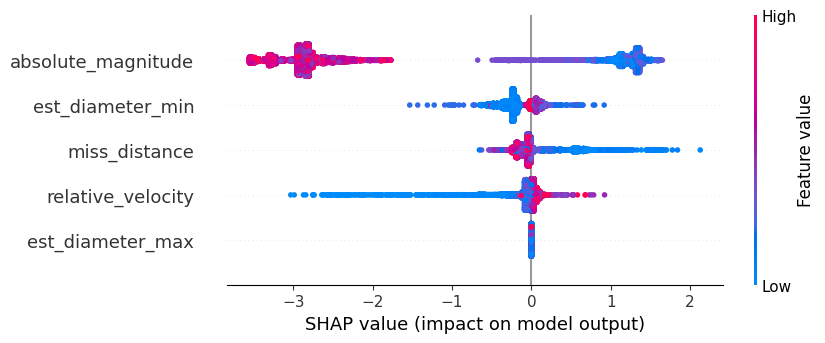

In [23]:
X_train_best = study.best_trial.user_attrs['X_train']
X_test_best = study.best_trial.user_attrs['X_test']
Y_train_best = study.best_trial.user_attrs['Y_train']
Y_test_best = study.best_trial.user_attrs['Y_test']

explanation = explainer(X_test_best)
shap.plots.beeswarm(explanation)

In [24]:
run_server(storage)

Bottle v0.13.2 server starting up (using WSGIRefServer())...
Listening on http://localhost:8080/
Hit Ctrl-C to quit.

127.0.0.1 - - [23/Dec/2024 17:31:09] "GET / HTTP/1.1" 302 0
127.0.0.1 - - [23/Dec/2024 17:31:09] "GET /dashboard HTTP/1.1" 304 0
127.0.0.1 - - [23/Dec/2024 17:31:09] "GET /static/bundle.js HTTP/1.1" 304 0
127.0.0.1 - - [23/Dec/2024 17:31:10] "GET /api/studies HTTP/1.1" 200 172
127.0.0.1 - - [23/Dec/2024 17:31:11] "GET /favicon.ico HTTP/1.1" 304 0
c:\Users\samud\Documents\Python_Learning\Asteroids\venv\Lib\site-packages\optuna_dashboard\_importance.py:75: ExperimentalWarning:

PedAnovaImportanceEvaluator is experimental (supported from v3.6.0). The interface can change in the future.

c:\Users\samud\Documents\Python_Learning\Asteroids\venv\Lib\site-packages\optuna\importance\_ped_anova\evaluator.py:150: UserWarning:

PedAnovaImportanceEvaluator computes the importances of params to achieve low `target` values. If this is not what you want, please modify target, e.g., by 